# Transfer Learning for Classification

**Please save a copy of the notebook in your local drive! Otherwise you will lose your progress.**

## Introduction & a Bit of History

Over the course of CS189, you have trained machine learning models for specific applications, whether it is classification or regression. Although this has been effective, modern machine learning researchers use a considerably different pipeline for training models.

What people have been doing instead is to train a massive model for a very broad objective, and then finetune the model on a smaller dataset. This approach has given us a lot of great-performing models and agents, the most notable being that of [GPT](https://arxiv.org/abs/2005.14165) models (there are also more models that does the same job, BERT, DINO, masked autoencoders are the ones that immediately came to mind, but unfortunately there are no equivalent in robotics), as they relied on internet scale pretraining (with GPT specifically, people use what's called next-token prediction as the objective). You don't need to know exactly how this works in this class, but this is drastically different than what we have done by fitting a model to exactly one dataset.

Of course, we do not have the computational resources to retrain any GPT3+ models, but we can try a smaller problem with transfer learning! Here is a little story behind the origin of transfer learning:

Back in 2013, neural-net based image recognition methods such as AlexNet has already swept through the ML community by storm, and people are trying to tackle the next problem in computer vision, which is object segmentation (using bounding boxes). The problem is that the corresponding dataset, [Pascal-VOC](https://paperswithcode.com/dataset/pascal-voc), is very small for neural networks (only 1500 training images and 20,000 data entries).

So what did people do? Researchers have found out is that instead of training a neural network from scratch, using weights from networks trained on [ImageNet classification](https://paperswithcode.com/sota/image-classification-on-imagenet) as the starting point actually helped to achieve very good tracking accuracy on these tasks (if you are so inclined, feel free to read [R-CNN](https://arxiv.org/pdf/1311.2524) to see what they have done)! In fact, this method worked so well that it not only inspired the idea of "pretraining" across the machine learning community, but also sparked a [funny bet](https://people.eecs.berkeley.edu/~efros/gelato_bet.html) between two UC Berkeley professors.

In previous semesters, we actually didn't want you to do transfer learning for CIFAR-10, but with how much the machine learning world has changed, we are changing the focus specifically on transfer learning to get you more familiar with these paradigms and hope you can have successes working with these large models!

## Transfer Learning for CIFAR-10

In this question, we will explore how to effectively use transfer learning to learn a new task with a *pretrained* network. In essence, the idea of pretraining is that a network has been trained on another objective, and that the weights are something more desirable than random initialization. Transfer learning takes advantage of that and aims to make training faster compared to that of training from scratch.

In [27]:
# utils for data loading

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import torchvision
import time
import numpy as np
import pandas as pd

import os
import time

import random
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Is CUDA available?", torch.cuda.is_available())
print("CUDA device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

Is CUDA available? True
CUDA device: NVIDIA GeForce RTX 3060 Laptop GPU


In [29]:
seed = 1899
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

First, let's start with making the necessary transformations of our training data. CIFAR-10 is a collection of 60,000 32x32x3 images divided into 10 classes. If you want more information, please refer to [this link](https://www.cs.toronto.edu/~kriz/cifar.html) by Alex Krizhevsky et al.

However, most of the models readily available are trained on ImageNet, which is 224x224x3. Although one can hack the weights of a neural network and design a new network on top of it, it is much easier to simply scale up the images by a factor of 7 (224/32) and feed the network the magnified images. Let's do that instead!

In [30]:
## transforms to match that of the transforms in ImageNet
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize to 224x224 (ImageNet size)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

## download training dataset
train_dataset = datasets.CIFAR10(root='./data', train=True,
                                 transform=transform, download=True)

test_dataset = datasets.CIFAR10(root='./data', train=False,
                                 transform=transform, download=True)

Let's also visualize some images within CIFAR-10 Dataset!

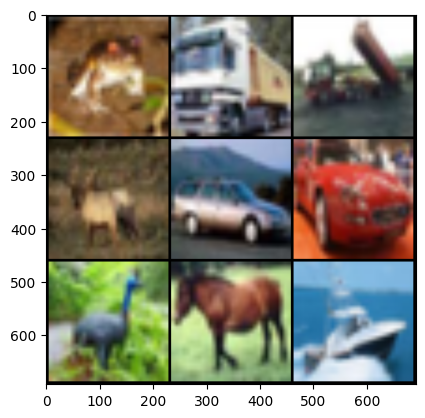

In [31]:
viz_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize to 224x224 (height x width)
    transforms.ToTensor(),
])

viz_dataset = datasets.CIFAR10(root='./data', train=True,
                                 transform=viz_transform, download=True)

images = [viz_dataset[i][0] for i in range(9)]
plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=3, padding=5).numpy().transpose((1, 2, 0)))

Now go to *torchvision.models* module, and pick one of the following models that you would like.

- VGG Networks (all VGG networks are fine)

- AlexNet

- ResNet-18, -34, or -50

A more expressive model, such as using vision transformers, will not be allowed (they also have hundreds of millions of parameters, which is not friendly for your colab compute units). All model weights must directly come from *torchvision.models* module.

In order to perform transfer learning, you should do the following steps:

1. Load a pretrained network on another dataset.
2. Freeze most of the layers of the pretrained network and discard a part of the network not relevant to your model.
3. Append a new MLP at the end of the network, and allow gradients to pass through the new MLP (and other non-frozen parts of the network).
4. Train the new network.

**Although we would like you to explore transfer learning, here are some rules you must follow:**

1. You may not change the model architecture other than the final linear layers.
2. You must freeze all of the weights in the convolutional layers.
3. You may not have more than 3 million trainable parameters.

In [32]:
from torch.optim import Adam
class TransferCIFAR10(nn.Module):
  def __init__(self, *args, **kwargs):
    raise NotImplementedError


  def forward(self, x):
    raise NotImplementedError

If you want to check how many trainable parameters are within your model, run this script here:

In [33]:
def num_trainable_params(model: nn.Module):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [34]:
# training script
################################# YOUR CODE HERE ###################################


### Kaggle Submission
The following code is for you to make your submission to kaggle. Here are the steps you must follow:

1. Upload `cifar-test-data-sp25.npy` to the colab notebook by going to files on the left hand pane, then hitting "upload". This file may take roughly a minute to upload and you should not proceed to the following steps until it has completely finished uploading (students in the past have run into issues where they were accidentally testing on a partially uploaded test set and getting garbage results).
2. Run the following cell to generate the dataset object for the test data. Feel free to modify the code to use the same transforms that you use for the training data. By default, this will re-use the `transform` variable.
3. In the second cell, write code to run predictions on the testing dataset and store them into an array called `predictions`.
4. Run the final cell which will convert your predictions array into a CSV for kaggle.
5. Go to the files pane again, and download the file called `submission.csv` by clicking the three dots and then download.


In [39]:
from PIL import Image
import os
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

class CIFAR10Test(torchvision.datasets.VisionDataset):

    def __init__(self, transform=None, target_transform=None):
        super(CIFAR10Test, self).__init__(None, transform=transform,
                                      target_transform=target_transform)
        assert os.path.exists("cifar10-test-data-sp25.npy"), "You must upload the test data to the file system."
        self.data = [np.load("cifar10-test-data-sp25.npy", allow_pickle=False)]

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

    def __getitem__(self, index: int):
        img = self.data[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self) -> int:
        return len(self.data)

# To save some hassle, we have provided the same transformation to be applied in the training data, but please
# change this if you were to modify your training approach compared to what we have.
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize to 224x224 (height x width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

# Create the test dataset
testing_data = CIFAR10Test(
    transform=transform, # NOTE: Make sure transform is the same as used in the training dataset.
)

Trainable parameters: 1973642
Epoch 1/10  Train Loss: 0.7313, Train Acc: 0.7531  |  Val   Loss: 0.5902, Val   Acc: 0.7972
Epoch 2/10  Train Loss: 0.5857, Train Acc: 0.7976  |  Val   Loss: 0.5712, Val   Acc: 0.8017
Epoch 3/10  Train Loss: 0.5325, Train Acc: 0.8141  |  Val   Loss: 0.5826, Val   Acc: 0.8012
Epoch 4/10  Train Loss: 0.5011, Train Acc: 0.8256  |  Val   Loss: 0.5313, Val   Acc: 0.8209
Epoch 5/10  Train Loss: 0.4618, Train Acc: 0.8392  |  Val   Loss: 0.5552, Val   Acc: 0.8062
Epoch 6/10  Train Loss: 0.4263, Train Acc: 0.8499  |  Val   Loss: 0.5387, Val   Acc: 0.8146
Epoch 7/10  Train Loss: 0.3910, Train Acc: 0.8626  |  Val   Loss: 0.5208, Val   Acc: 0.8222
Epoch 8/10  Train Loss: 0.3547, Train Acc: 0.8762  |  Val   Loss: 0.5552, Val   Acc: 0.8088
Epoch 9/10  Train Loss: 0.3165, Train Acc: 0.8888  |  Val   Loss: 0.5367, Val   Acc: 0.8217
Epoch 10/10  Train Loss: 0.2848, Train Acc: 0.9005  |  Val   Loss: 0.5294, Val   Acc: 0.8286


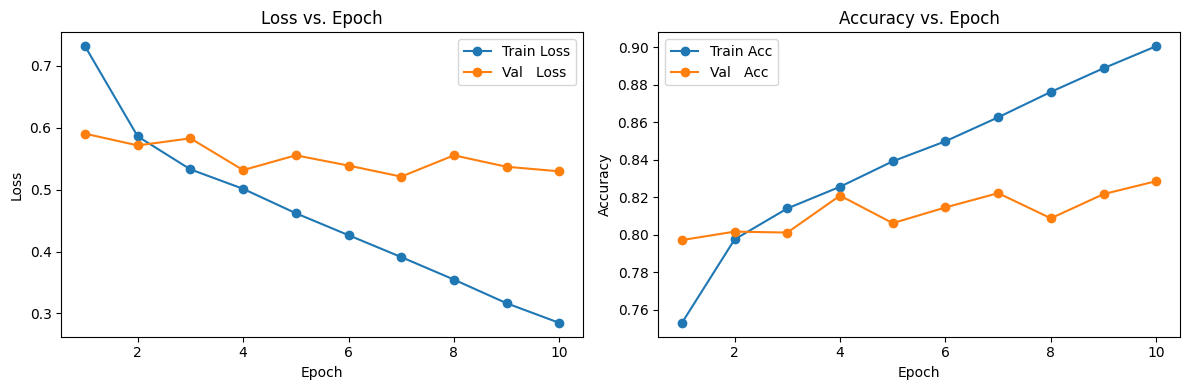

In [40]:
### YOUR CODE HERE ###

# Recommendation: create a `test_dataloader` from torch.utils.data.DataLoader with `shuffle=False` to iterate over the test data in batches.

# Store a numpy vector of the predictions for the test set in the variable `predictions`.


#Model ResNet 18
class TransferCIFAR10(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = models.resnet18(pretrained=True)

        for param  in backbone.parameters():
            param.requires_grad = False

        in_feats = backbone.fc.in_features  
        backbone.fc = nn.Sequential(
            nn.Linear(in_feats, 1920),  
            nn.ReLU(inplace=True),
            nn.Linear(1920, 512),      
            nn.ReLU(inplace=True),
            nn.Linear(512, 10),        
        )
        self.backbone = backbone

    def forward(self, x):
        return self.backbone(x)
    
model = TransferCIFAR10().to(device)
print("Trainable parameters:", num_trainable_params(model))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=4, pin_memory=True)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.backbone.fc.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

n_epochs = 10
train_losses, val_losses = [], []
train_accuracy,   val_accuracy   = [], []

for epoch in range(1, n_epochs+1):
    # — train —
    model.train()
    train_loss = 0
    train_correct = 0
    train_total   = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(X)
        loss   = criterion(logits, y)
        loss.backward()
        optimizer.step()

        train_loss    += loss.item() * X.size(0)
        preds          = logits.argmax(dim=1)
        train_correct += (preds == y).sum().item()
        train_total   += X.size(0)

    train_losses.append(train_loss / train_total)
    train_accuracy.append(train_correct / train_total)

    # — validate —
    model.eval()
    val_loss    = 0
    val_correct = 0
    val_total   = 0

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss   = criterion(logits, y)

            val_loss    += loss.item() * X.size(0)
            preds        = logits.argmax(dim=1)
            val_correct += (preds == y).sum().item()
            val_total   += X.size(0)

    val_losses.append(val_loss / val_total)
    val_accuracy.append(val_correct / val_total)

    print(f"Epoch {epoch}/{n_epochs}  "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy[-1]:.4f}  |  "
          f"Val   Loss: {val_losses[-1]:.4f}, Val   Acc: {val_accuracy[-1]:.4f}")


epochs = range(1, n_epochs+1)
epochs = range(1, n_epochs+1)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, '-o', label="Train Loss")
plt.plot(epochs, val_losses,   '-o', label="Val   Loss")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracy, '-o', label="Train Acc")
plt.plot(epochs, val_accuracy,   '-o', label="Val   Acc")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

plt.tight_layout()
plt.show()

In [42]:
# Recommendation: create a `test_dataloader` from torch.utils.data.DataLoader with `shuffle=False` to iterate over the test data in batches.
test_loader = DataLoader(testing_data, batch_size=64, shuffle=False)

# Store a numpy vector of the predictions for the test set in the variable `predictions`.
model.eval()
predictions = []

with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())

predictions = np.array(predictions)


In [43]:
# This code below will generate kaggle_predictions.csv file. Please download it and submit to kaggle.
import pandas as pd

if isinstance(predictions, np.ndarray):
    predictions = predictions.astype(int)
else:
    predictions = np.array(predictions, dtype=int)
assert predictions.shape == (len(testing_data),), "Predictions were not the correct shape"
df = pd.DataFrame({'Category': predictions})
df.index += 1  # Ensures that the index starts at 1.
df.to_csv('1submission.csv', index_label='Id')

# Now download the submission.csv file to submit.